## Can I Extract Main Topics or sentiment within the highest or lowest scoring comments?

In [5]:
sw = pd.read_csv('../Datasets_capstone/sw_final.csv', encoding='utf8', engine='python')
del sw['Unnamed: 0']

In [6]:
sw.drop_duplicates('comment_body', keep='first', inplace=True)

## Sampling

There are unequal class sizes when splitting the y variable into 4. I attempted different up and down sampling techniques, including SMOTE and random under sampling.

- I chose the down sampling method as it was computationally the fastest and easy in implementation.
- Limitation: Possibly gets rid of important data (randomly downsamples to the smallest class)

In [7]:
def sampling(X,y): 
    y_b = pd.qcut(y, 4, labels = [0,1,2,3])
    print(pd.qcut(y, 4).value_counts())
    Xs,ys = RandomUnderSampler(replacement = True).fit_resample(X, y_b)  
    Xs = pd.DataFrame(Xs, columns = X.columns)
    ys = pd.DataFrame(ys, columns=['comment_score'])
    df = pd.concat([Xs, ys], axis=1) 
    return df

In [8]:
df_split = sampling(sw[['comment_body']] ,sw['comment_score'])

(1.0, 3.0]        4576
(-84.001, 1.0]    4230
(10.0, 1125.0]    3791
(3.0, 10.0]       3678
Name: comment_score, dtype: int64


I am going to focus on the top and bottom rated scored comments
- Remove punctuation
- Convert to lowercase

In [11]:
lowest_comments = df_split[(df_split.comment_score ==0)] 
# lowmed_comments = df_split[(df_split.comment_score==1)]
# highmed_comments = df_split[(df_split.comment_score==2)]
highest_comments = df_split[(df_split.comment_score==3)]

In [14]:
lowest_comments['comment_body'] = lowest_comments['comment_body'].map(lambda x: re.sub('[,\.!?]', '', x))
lowest_comments['comment_body'] = lowest_comments['comment_body'].map(lambda x: x.lower())
lowest_comments[['comment_body']].head()

,comment_body
0,yeah had a terrible week after that i'm mad i ...
1,have you worked with a counselor and psychiatr...
2,i'm really thinking about deleting whatsapp an...
3,i relate to this post so much i hate my birt...
4,when i was young my grandmother passed away th...


In [15]:
highest_comments['comment_body'] = highest_comments['comment_body'].map(lambda x: re.sub('[,\.!?]', '', x))
highest_comments['comment_body'] = highest_comments['comment_body'].map(lambda x: x.lower())
highest_comments[['comment_body']].head()

,comment_body
11034,yeah i pretend to be happy but also hope someo...
11035,"don't forget ""have you tried just being happy""..."
11036,you all can be okay together with me and anoth...
11037,the truth is your parents fucked up reach for ...
11038,i got my bachelors in a practical field but i ...


## Lowest comments word cloud 

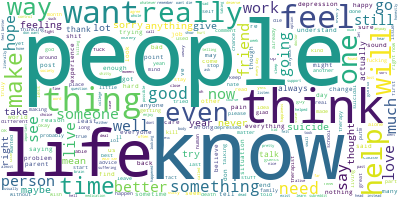

In [16]:
long_string = ','.join(list(lowest_comments['comment_body'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

## Highest comments word cloud

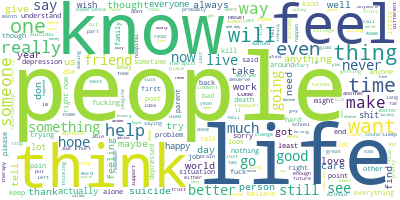

In [17]:
long_string = ','.join(list(highest_comments['comment_body'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

## 10 most common words in lowest scoring comments 

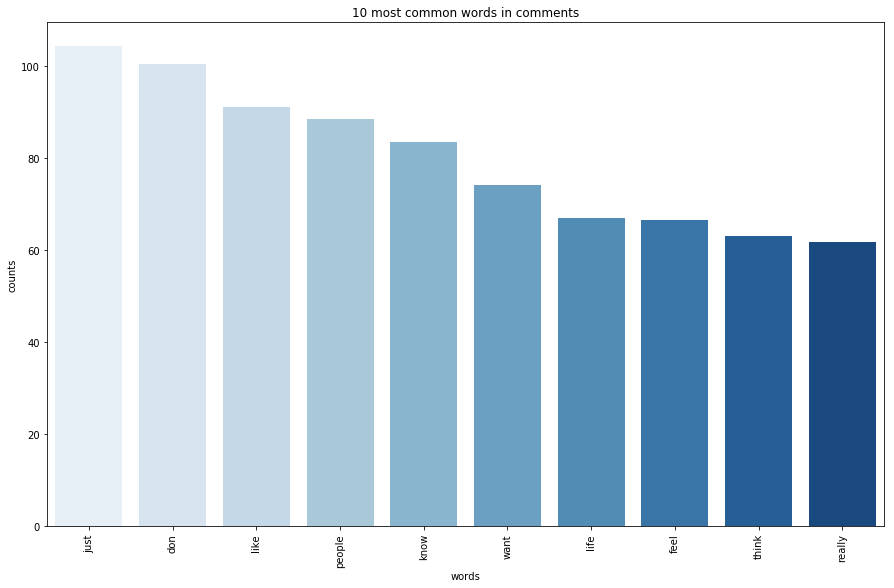

In [18]:
sns.set_palette('Blues_r', n_colors=4, desat=1)

def plot_10_most_common_words(count_data, tvec):
    import matplotlib.pyplot as plt
    words = tvec.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words in comments')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='Blues')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
tvec = TfidfVectorizer(stop_words='english')
count_data_low = tvec.fit_transform(lowest_comments['comment_body'])
plot_10_most_common_words(count_data_low, tvec)

## 10 most common words in highest scoring comments 

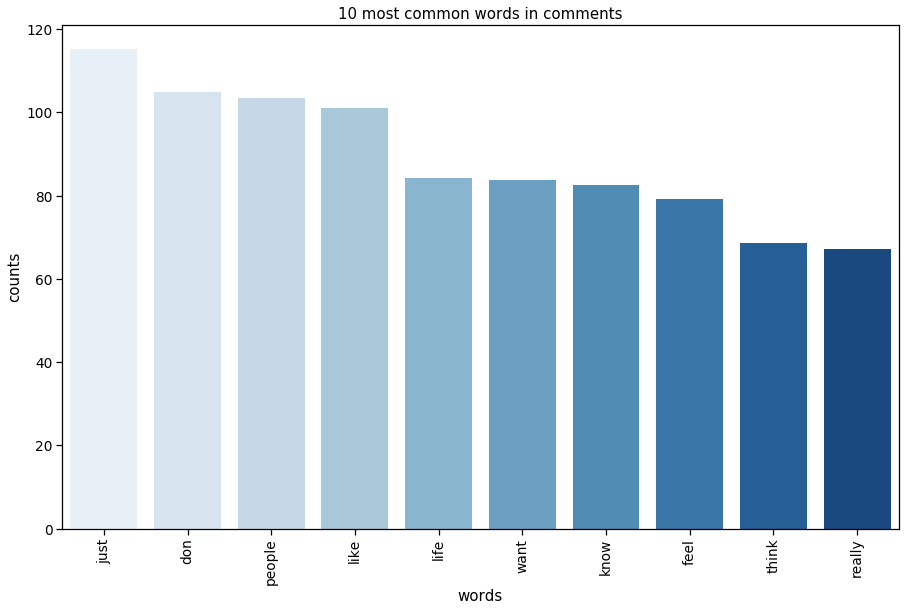

In [22]:
count_data_high = tvec.fit_transform(highest_comments['comment_body'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data_high, tvec)

The 10 most frequent words are found to be almost the same in both the high and low scoring comments. This is unsuprising as the topics in the suicide threads are found to be relatively consistent accross all comments. 

## Topics using LDA
- Ran LDA using Tfidf model which used unsupervised learning to return topic clusters for the whole corpus
- Gensim returns the topic distribution, with each element in the list is a pair of a topic's id, and the probability that was assigned to it.

**Drawbacks**

- Required lots of optimisation
- Importance of each topic was not ranked
- Topics were found to be very similar in both high and low scoring comments (similar to SIA)

## Topics found associated with low scoring comments

In [20]:
def print_topics(model, tvec, n_top_words):
    words = tvec.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Can tweak the two parameters below
number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data_low)
# Print the topics found by the LDA model
print("LOW SCORING Topics found via LDA:")
print_topics(lda, tvec, number_words)

LOW SCORING Topics found via LDA:

Topic #0:
live just day want don cake getting fucking help thank

Topic #1:
don just people know want feel like really think life

Topic #2:
ve trying best gone doctor ones wonder life good just

Topic #3:
just ve comment like friend time fake different people life

Topic #4:
mean sub know got stop broke hate need think going

Topic #5:
fuck like know just good don hear make people ll

Topic #6:
just yeah yes like read don people thank thing die

Topic #7:
like ve pain people control just don oh life 10

Topic #8:
love glad old person good long hey gets amazing better

Topic #9:
sorry did didn help talk need better life drugs work


## Topics found associated with high scoring comments

In [23]:
lda.fit(count_data_high)
print("HIGH SCORING Topics found via LDA:")
print_topics(lda, tvec, number_words)

HIGH SCORING Topics found via LDA:

Topic #0:
im going time don really sorry world just want like

Topic #1:
just like want kill don feel person people die wait

Topic #2:
feel like people don just know life say good help

Topic #3:
sorry dude like people life wish just luck story im

Topic #4:
thank don people just time want live depression life feel

Topic #5:
just know old kids don really life love god people

Topic #6:
just people don hope really life like yeah want know

Topic #7:
know just like think don want talk people life way

Topic #8:
don just time help want life day better hope ve

Topic #9:
life die want birthday happy fighting pay people somebody commit


**Data prep:**
- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- All stopwords are removed.
- Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Words are stemmed — words are reduced to their root form.

In [24]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

In [32]:
processed_docs = lowest_comments['comment_body'].map(preprocess)
processed_docs[:5]

0    [yeah, terribl, week, mad, lie, friend, mad, p...
1    [work, counselor, psychiatrist, drop, hat, emb...
2    [think, delet, whatsapp, stop, contact, best, ...
3    [relat, post, hate, birthday, feel, lone, reme...
4    [young, grandmoth, pass, away, person, know, c...
Name: comment_body, dtype: object

Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the doc.

In [33]:
dictionary = gensim.corpora.Dictionary(processed_docs)

Filter out tokens that are extreme and appear in:
- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 100000 most frequent tokens.

*If incredibly rare, the words will not be able to predict much, and if common, then they will not be super important*

In [257]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

Create a dictionary reporting how many words and how many times those words appear.

In [34]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

Running LDA using TF-IDF

- Salient topics are difficult to pinpoint; there is significant overlap between words found in different topics.

In [53]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"like" + 0.004*"know" + 0.004*"think" + 0.004*"feel" + 0.004*"sorri" + 0.004*"ve" + 0.004*"care" + 0.004*"good" + 0.004*"peopl" + 0.004*"thank"
Topic: 1 Word: 0.009*"want" + 0.007*"help" + 0.007*"peopl" + 0.006*"feel" + 0.005*"ok" + 0.005*"know" + 0.005*"better" + 0.005*"get" + 0.005*"need" + 0.005*"way"
Topic: 2 Word: 0.006*"tri" + 0.004*"ll" + 0.004*"think" + 0.004*"go" + 0.004*"kill" + 0.003*"fuck" + 0.003*"love" + 0.003*"age" + 0.003*"hate" + 0.003*"help"
Topic: 3 Word: 0.007*"know" + 0.006*"love" + 0.006*"better" + 0.006*"like" + 0.006*"think" + 0.005*"want" + 0.005*"thing" + 0.005*"feel" + 0.004*"mean" + 0.004*"help"
Topic: 4 Word: 0.005*"life" + 0.005*"hope" + 0.005*"peopl" + 0.005*"live" + 0.005*"feel" + 0.004*"like" + 0.004*"person" + 0.004*"know" + 0.004*"ve" + 0.003*"go"


Performance evaluation by classifying sample document using LDA TF-IDF model.

In [54]:
for index, score in sorted(lda_model_tfidf[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.864258885383606	 
Topic: 0.006*"like" + 0.004*"know" + 0.004*"think" + 0.004*"feel" + 0.004*"sorri" + 0.004*"ve" + 0.004*"care" + 0.004*"good" + 0.004*"peopl" + 0.004*"thank"

Score: 0.033963244408369064	 
Topic: 0.009*"want" + 0.007*"help" + 0.007*"peopl" + 0.006*"feel" + 0.005*"ok" + 0.005*"know" + 0.005*"better" + 0.005*"get" + 0.005*"need" + 0.005*"way"

Score: 0.03393969312310219	 
Topic: 0.007*"know" + 0.006*"love" + 0.006*"better" + 0.006*"like" + 0.006*"think" + 0.005*"want" + 0.005*"thing" + 0.005*"feel" + 0.004*"mean" + 0.004*"help"

Score: 0.03392185643315315	 
Topic: 0.005*"life" + 0.005*"hope" + 0.005*"peopl" + 0.005*"live" + 0.005*"feel" + 0.004*"like" + 0.004*"person" + 0.004*"know" + 0.004*"ve" + 0.003*"go"

Score: 0.03391631320118904	 
Topic: 0.006*"tri" + 0.004*"ll" + 0.004*"think" + 0.004*"go" + 0.004*"kill" + 0.003*"fuck" + 0.003*"love" + 0.003*"age" + 0.003*"hate" + 0.003*"help"
